In [7]:
#### boiler plate code
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [9]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # 30,64
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1 # 27 x 64
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [10]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [11]:
Ytr[ix]

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

In [12]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation 32 examples x 64 output neurons(32 egs x 30 emb   x   30 x 64 = 32 egs x 64)

# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True) # 1 x 164

bndiff = hprebn - bnmeani # 32 x 64 - 1 x 64 (broadcast 64 times) = 32 x 64
bndiff2 = bndiff**2 # squaring each term - 32 x 64
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n) # 1 x 64

print('bnvar ',bnvar.shape) 
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
print('probs', logprobs.shape)
loss = -logprobs[range(n), Yb].mean()


# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

bnvar  torch.Size([1, 64])
probs torch.Size([32, 27])


tensor(3.3252, grad_fn=<NegBackward0>)

In [13]:
### back prop step by step
# loss = 1/32(-loss1 + -loss2 + -loss3 ... -loss32)
# dloss/logprobs = -1/32 the ones that are participating, Yb column ones
# dloss/logprobs = 0, the rest of the columns
dloss_by_dlogprobs = torch.zeros(32,27)
dloss_by_dlogprobs[range(n), Yb] = -1/32

cmp('dloss/dlogprobs', dloss_by_dlogprobs, logprobs)

dlogprobs_by_dprobs = 1/probs
dloss_by_dprobs = dloss_by_dlogprobs * dlogprobs_by_dprobs

cmp('dloss/dprobs ', dloss_by_dprobs, probs)

dprobs_by_dcounts_sum_inv = counts
dloss_by_dcounts_sum_inv = (dprobs_by_dcounts_sum_inv * dloss_by_dprobs).sum(1, keepdim=True)

# 32 x 27
# 2 example, 2 x 27
# probs = counts=2 x 27  * counts_sum_inv=2 x 1(2 x 27)
# c1*a c2*a ,,,c27*a
# d1*b d2*b ,,,d27*b
# loss due to a will be additive!
# c1 + c2 + c3..
# d1 + d2 + d3..
cmp('dloss_by_dcounts_sum_inv', dloss_by_dcounts_sum_inv, counts_sum_inv)
# print(dloss_by_dcounts_sum_inv.shape)

# print(counts.shape) # 32 x 27
dprobs_by_dcounts = counts_sum_inv
# print(dprobs_by_dcounts.shape) # 32 x 1
# print(dloss_by_dprobs.shape) # 32 x 27
dloss_by_dcounts = dprobs_by_dcounts * dloss_by_dprobs # 32 x 27
# print(dloss_by_dcounts.shape)
# cmp('dloss_by_dcounts', dloss_by_dcounts, counts)
# THIS IS FALSE BECAUSE counts is used at 2 places, other contri is not counted

# print(counts_sum_inv.shape) # 32 x 1
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# print(counts_sum.shape) # 32 x 1
dcounts_sum_inv_by_dcounts_sum = -(counts_sum**-2)
dloss_by_dcounts_sum = dloss_by_dcounts_sum_inv * dcounts_sum_inv_by_dcounts_sum
cmp('dloss_by_dcounts_sum',dloss_by_dcounts_sum, counts_sum)

# counts_sum = counts.sum(1, keepdims=True)
# print(counts_sum.shape) # 32 x 1
# print(counts.shape) # 32 x 27
# 32 x 27 -> 32 x 1 
# a1 a2 a27
# b1 b2 b27

dcounts_sum_by_dcounts = torch.ones(32,27)
dloss_by_dcounts += dloss_by_dcounts_sum * dcounts_sum_by_dcounts
cmp('dloss_by_dcounts',dloss_by_dcounts,counts)

# counts = norm_logits.exp()
dcounts_by_dnorm_logits = norm_logits.exp()
dloss_by_dnorm_logits = dloss_by_dcounts * dcounts_by_dnorm_logits
cmp('dloss_by_dnorm_logits', dloss_by_dnorm_logits, norm_logits)


# norm_logits = logits - logit_maxes # subtract max for numerical stability
# print(logits.shape) # 32 x 27
# print(logit_maxes.shape) # 32 x 1
dnorm_logits_by_dlogits = torch.ones_like(logits)
dloss_by_dlogits = dloss_by_dnorm_logits * dnorm_logits_by_dlogits
# cmp('dloss_by_dlogits',dloss_by_dlogits,logits)
# This will be false because logits has one more branch

# print(logit_maxes.shape) # 32 x 1
dnorm_logits_by_dlogit_maxes = -1.0 * torch.ones(32,1)
dloss_by_dlogit_maxes = dloss_by_dnorm_logits.sum(1, keepdim=True) * dnorm_logits_by_dlogit_maxes
# print(dnorm_logits_by_dlogit_maxes.shape) # 32 x 1
# print(dloss_by_dnorm_logits.shape) # 32 x 27
cmp('dloss_by_dlogit_maxes', dloss_by_dlogit_maxes, logit_maxes)


# logit_maxes = logits.max(1, keepdim=True).values
# print(logits.shape) # 32 x 27
dlogit_maxes_by_dlogits = F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])
dloss_by_dlogits += dloss_by_dlogit_maxes * dlogit_maxes_by_dlogits
# print(dloss_by_dlogits.shape) # 32 x 27
cmp('dloss_by_dlogits',dloss_by_dlogits,logits)

# print(dloss_by_dlogits.shape) # 32 x 27
# logits = h @ W2 + b2 # output layer
# print(logits.shape, h.shape, W2.shape, b2.shape)
# torch.Size([32, 27]) torch.Size([32, 64]) torch.Size([64, 27]) torch.Size([27])
dlogits_by_dh = W2 # 64 x 27
dloss_by_dh = dloss_by_dlogits @ torch.transpose(dlogits_by_dh,0,1)
# print(dloss_by_dh.shape) # 32 x 64
# torch.Size([32, 64]) =  ,32 x 27 @ 64 x 27'
cmp('dloss_by_dh', dloss_by_dh, h)

# W2.shape = 64 x 27, we want
# loss/logits = 32 x 27
# logits/W2 = 32 x 64

# 32 x 64 ' @ 32 x 27 = 64 x 27
dlogits_by_dW2 = h # 32 x 64
dloss_by_dW2 = torch.transpose(dlogits_by_dW2,0,1) @ dloss_by_dlogits
# print(dloss_by_dW2.shape) # 64 x 27
cmp('dloss_by_dW2', dloss_by_dW2, W2)

# b2.shape = 27
dlogits_by_db2 = torch.ones_like(b2)
dloss_by_db2 = dloss_by_dlogits.sum(0,keepdim=True) * dlogits_by_db2
# print(dloss_by_db2.shape) # 1 x 27
cmp('dloss_by_db2', dloss_by_db2, b2)

# h = torch.tanh(hpreact) # hidden layer
# print(hpreact.shape) # 32 x 64
#  print(dloss_by_dh.shape) # 32 x 64
dh_by_dhpreact = 1.0 - h**2
# print(dh_by_dhpreact.shape)
dloss_by_dhpreact = dh_by_dhpreact * dloss_by_dh
# print(dloss_by_dhpreact.shape) # 32 x 64
cmp('dloss_by_dhpreact', dloss_by_dhpreact, hpreact)

# hpreact = bngain * bnraw + bnbias
# print(bngain.shape) # 1 x 64
# print(bnraw.shape) # 32 x 64
# print(dloss_by_dhpreact.shape) # 32 x 64

dhpreact_by_dbngain = bnraw
# print(dhpreact_by_dbngain.shape) # 32 x 64
dloss_by_dbngain = (dloss_by_dhpreact * dhpreact_by_dbngain).sum(0, keepdim=True)
# print(dloss_by_dbngain.shape) # 1 x 64
cmp('dloss_by_dbngain', dloss_by_dbngain, bngain)


# print(bnraw.shape) # 32 x 64
dhpreact_by_dbnraw = bngain
# print(dhpreact_by_dbnraw.shape) # 1 x 64
# print(dloss_by_dhpreact.shape) # 32 x 64
dloss_by_dbnraw = (dloss_by_dhpreact * dhpreact_by_dbnraw)
# print(dloss_by_dbnraw.shape) # 32 x 64
cmp('dloss_by_dbnraw', dloss_by_dbnraw, bnraw)

# print(bnbias.shape) # 1 x 64
dhpreact_by_dbnbias = torch.ones_like(bnbias)
dloss_by_dbnbias = (dloss_by_dhpreact * dhpreact_by_dbnbias).sum(0, keepdim=True)
# print(dloss_by_dbnbias.shape)
cmp('dloss_by_dbnbias', dloss_by_dbnbias, bnbias)

# bnraw = bndiff * bnvar_inv
# print(bndiff.shape) # 32 x 64
# print(bnvar_inv.shape) # 1 x 64
dbnraw_by_dbndiff = bnvar_inv
# print(dloss_by_dbnraw.shape) # 32 x 64
dloss_by_dbndiff = dloss_by_dbnraw * dbnraw_by_dbndiff
# dloss_by_dbndiff = bnvar_inv* (bngain*(1.0-h**2)*(dloss_by_dlogits @ W2.T))
# print(dloss_by_dbndiff.shape) # 32 x 64
# cmp('dloss_by_dbndiff',dloss_by_dbndiff, bndiff)
# THIS IS FALSE BECAUSE ITS NOT YET DONE

dbnraw_by_dbnvar_inv = bndiff
# print(dbnraw_by_dbnvar_inv.shape) # 32 x 64
dloss_by_dbnvar_inv = (dloss_by_dbnraw * dbnraw_by_dbnvar_inv).sum(0, keepdim=True)
cmp('dloss_by_dbnvar_inv', dloss_by_dbnvar_inv, bnvar_inv)

# bnvar_inv = (bnvar + 1e-5)**-0.5
# print(bnvar.shape)  1 x 64
dbnvar_inv_by_dbnvar = -0.5*(bnvar +  1e-5)**-1.5
# print(dbnvar_inv_by_dbnvar.shape) # 1 x 64
# print(dloss_by_dbnvar_inv.shape)# 1 x 64
dloss_by_dbnvar = dloss_by_dbnvar_inv * dbnvar_inv_by_dbnvar
# print(dloss_by_dbnvar.shape) # 1 x 64
cmp('dloss_by_dbnvar',dloss_by_dbnvar, bnvar)

# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n) # 1 x 64
# print(bnvar.shape) # 1 x 64
# print(bndiff2.shape) # 32 x 64
dbnvar_by_dbndiff2 = 1/(n-1)*torch.ones(32,64)
dloss_by_dbndiff2 = dloss_by_dbnvar * dbnvar_by_dbndiff2
cmp('dloss_by_dbndiff2',dloss_by_dbndiff2, bndiff2) 


# bndiff2 = bndiff**2 # squaring each term - 32 x 64
dbndiff2_by_dbndiff = 2*bndiff
dloss_by_dbndiff += dloss_by_dbndiff2 * dbndiff2_by_dbndiff
cmp('dloss_by_dbndiff',dloss_by_dbndiff,bndiff)

# bndiff = hprebn - bnmeani # 32 x 64 - 32 x 1 (broadcast 64 times) = 32 x 64
# print(bndiff.shape) # 32 x 64
# print(hprebn.shape) # 32 x 64
# print(bnmeani.shape) # 1 x 64
dbndiff_by_dhprebn = torch.ones(32,64)
dloss_by_dhprebn = dloss_by_dbndiff * dbndiff_by_dhprebn
# print(dloss_by_dhprebn.shape) # 32 x 64
# cmp('dloss_by_dhprebn',dloss_by_dhprebn, hprebn)
# THIS IS FALSE, BECAUSE THERE IS ANOTHER BRANCH of hprebn

dbndiff_by_dbnmeani = -1.0*torch.ones(1,64)
dloss_by_dbnmeani = (dloss_by_dbndiff * dbndiff_by_dbnmeani).sum(0, keepdim=True)
# print(dloss_by_dbmeani.shape)
cmp('dloss_by_dbnmeani',dloss_by_dbnmeani, bnmeani)
# print(dloss_by_dbndiff.shape) # 32 x 64

# bnmeani = 1/n*hprebn.sum(0, keepdim=True) # 32 x 1
dbnmeani_by_dhprebn = 1/n * torch.ones(32,64)
dloss_by_dhprebn += dloss_by_dbnmeani * dbnmeani_by_dhprebn
cmp('dloss_by_dhprebn',dloss_by_dhprebn, hprebn)

# hprebn = embcat @ W1 + b1 # hidden layer pre-activation 32 examples x 64 output neurons(32 egs x 30 emb   x   30 x 64 = 32 egs x 64)
# print(hprebn.shape)  # 32 x 64
# print(embcat.shape) # 32 x 30
# print(W1.shape) # 30 x 64
# print(b1.shape) # 64
dhprebn_by_dembcat = W1 # 30 x 64
# 32 x 30 = 64 x 32. T @ 30 x 64. T  
# print(dloss_by_dhprebn.shape)# 32 x 64
dloss_by_dembcat = dloss_by_dhprebn @ dhprebn_by_dembcat.T
# print(dloss_by_dembcat.shape)
cmp('dloss_by_dembcat', dloss_by_dembcat, embcat)

dhprebn_by_dW1 = embcat # 32 x 30
# 30 x 64 = 32 x 30.T  @ 32 x 64  
dloss_by_dW1 = dhprebn_by_dW1.T @ dloss_by_dhprebn
# print(dloss_by_dW1.shape)
cmp('dloss_by_dW1',dloss_by_dW1, W1)

dhprebn_by_db1 = torch.ones_like(b1)
dloss_by_db1 = (dloss_by_dhprebn * dhprebn_by_db1).sum(0,keepdim=True)
# print(dloss_by_db1.shape)
cmp('dloss_by_db1',dloss_by_db1, b1)

# embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# dembcat_by_demb = 
# print(emb.shape) # 32 x 3 x 10
# dembcat_by_demb = torch.ones(32,3,10)
dloss_by_demb = dloss_by_dembcat.view(emb.shape)
cmp('dloss_by_demb',dloss_by_demb,emb)
# if u change emb by delta, the only way loss will change is by reshaping the loss of next step - embcat
# print(dloss_by_dembcat.shape) # 32 x 30

# emb = C[Xb] # embed the characters into vectors
# demb_by_C = 
# print(C.shape) # 27 x 10

dloss_by_dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dloss_by_dC[ix,:] += dloss_by_demb[k,j,:]

cmp('dloss_by_dC',dloss_by_dC,C)
        
# print(Xb.shape) # 32 x 3
# print(dloss_by_demb.shape)




dloss/dlogprobs | exact: True  | approximate: True  | maxdiff: 0.0
dloss/dprobs    | exact: True  | approximate: True  | maxdiff: 0.0
dloss_by_dcounts_sum_inv | exact: True  | approximate: True  | maxdiff: 0.0
dloss_by_dcounts_sum | exact: True  | approximate: True  | maxdiff: 0.0
dloss_by_dcounts | exact: True  | approximate: True  | maxdiff: 0.0
dloss_by_dnorm_logits | exact: True  | approximate: True  | maxdiff: 0.0
dloss_by_dlogit_maxes | exact: True  | approximate: True  | maxdiff: 0.0
dloss_by_dlogits | exact: True  | approximate: True  | maxdiff: 0.0
dloss_by_dh     | exact: True  | approximate: True  | maxdiff: 0.0
dloss_by_dW2    | exact: True  | approximate: True  | maxdiff: 0.0
dloss_by_db2    | exact: True  | approximate: True  | maxdiff: 0.0
dloss_by_dhpreact | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
dloss_by_dbngain | exact: False | approximate: True  | maxdiff: 2.0954757928848267e-09
dloss_by_dbnraw | exact: False | approximate: True  | maxdiff

In [15]:
# logits = h @ W2 + b2 # output layer
# # cross entropy loss (same as F.cross_entropy(logits, Yb))
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# print('probs', logprobs.shape)
# loss = -logprobs[range(n), Yb].mean()

# dloss_by_dlogits?
# logits.shape
sub1 = torch.zeros(32,27)
sub1[range(n),Yb] = 1
dloss_by_dlogits = (torch.exp(logits)/torch.exp(logits).sum(1, keepdim=True) - sub1)
dloss_by_dlogits = dloss_by_dlogits/n

cmp('dloss_by_dlogits',dloss_by_dlogits, logits)

dloss_by_dlogits | exact: False | approximate: True  | maxdiff: 5.122274160385132e-09


tensor([ 0.0024,  0.0028,  0.0006,  0.0015,  0.0006,  0.0024,  0.0008,  0.0011,
        -0.0307,  0.0010,  0.0011,  0.0013,  0.0012,  0.0008,  0.0012,  0.0005,
         0.0003,  0.0006,  0.0005,  0.0016,  0.0016,  0.0006,  0.0008,  0.0022,
         0.0017,  0.0008,  0.0007], grad_fn=<SelectBackward0>)


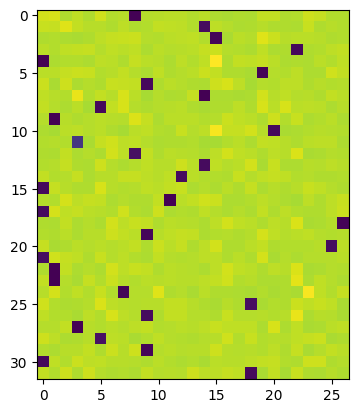

In [16]:
plt.imshow(dloss_by_dlogits.detach())
print(dloss_by_dlogits[0])

In [21]:
# hprebn = embcat @ W1 + b1 # hidden layer pre-activation 32 examples x 64 output neurons(32 egs x 30 emb   x   30 x 64 = 32 egs x 64)

# # BatchNorm layer
# bnmeani = 1/n*hprebn.sum(0, keepdim=True) # 1 x 64

# bndiff = hprebn - bnmeani # 32 x 64 - 1 x 64(broadcast 64 times) = 32 x 64
# bndiff2 = bndiff**2 # squaring each term - 32 x 64
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n) # 1 x 64

# print('bnvar ',bnvar.shape) 
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias
hprebn.shape
# bnmeani.shape

torch.Size([32, 64])

In [ ]:

## BIGGEST misconception
# batch normalization is to normalize outputs of a single neuron for all batches
# basically you take mean across all batches, NOT across all neurons
# hence its called batch normalization, makes sense only when neural network is trained batch wise.

# 64 neurons, 32 batches, u take average across 32 batches and get 1 x 64